# Datos de crusero, obtener la cantidad de tripulantes necesarios (crew)

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("cruise").getOrCreate()

In [2]:
url = "C:/Users/solk1/OneDrive/Desktop/Ciencia de datos/Spark_con_python/Python-and-Spark-for-Big-Data-master/Python-and-Spark-for-Big-Data-master/Spark_for_Machine_Learning/Linear_Regression"
data = spark.read.csv(url + "/cruise_ship_info.csv", inferSchema = True, header = True)

In [3]:
data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [4]:
data.printSchema() #Querremos que la columna Cruise_line sea numérica (one hot encoding)

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [8]:
data.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [33]:
#Para tener la columna Cruise_line (que es categórica) con valores numéricos:
from pyspark.ml.feature import StringIndexer

In [34]:
indexer = StringIndexer(inputCol = "Cruise_line", outputCol = "cruise_cat")
indexed = indexer.fit(data).transform(data)

In [35]:
indexed.show() #Listo, ya tenemos la nueva columna con datos numéricos

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+----------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|cruise_cat|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+----------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|      16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|      16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|       1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|       1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|       1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|       1.0|
|    Elation|   Carnival| 15

In [36]:
data = indexed

In [37]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [38]:
vector = VectorAssembler(inputCols = ['Age',
                                     'Tonnage',
                                     'passengers',
                                     'length',
                                     'cabins',
                                     'passenger_density',
                                     'cruise_cat'],
                        outputCol = "features")

In [39]:
output = vector.transform(data)
output.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- cruise_cat: double (nullable = false)
 |-- features: vector (nullable = true)



In [40]:
dataf = output.select("features", "crew")

In [41]:
train, test = dataf.randomSplit([0.7, 0.3])

In [17]:
from pyspark.ml.regression import LinearRegression

In [42]:
lr = LinearRegression(featuresCol = "features", labelCol = "crew", predictionCol = "prediction")

In [43]:
lr_model = lr.fit(train)

In [54]:
test_results = lr_model.evaluate(test)

In [55]:
#error medio cuadrático, su raíz
test_results.rootMeanSquaredError

0.7334811152474384

In [56]:
test_restults.r2

0.8749879974708343

In [57]:
dataf.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [58]:
datos_sin_label = dataf.select("features")

In [59]:
prediccion = lr_model.transform(datos_sin_label)

In [60]:
prediccion.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[6.0,30.276999999...| 4.225395998288252|
|[6.0,30.276999999...| 4.225395998288252|
|[26.0,47.262,14.8...| 6.417833710265149|
|[11.0,110.0,29.74...|12.270510139104319|
|[17.0,101.353,26....|10.875882759874086|
|[22.0,70.367,20.5...| 8.764667035942464|
|[15.0,70.367,20.5...| 8.862817630621478|
|[23.0,70.367,20.5...| 8.762870303032068|
|[19.0,70.367,20.5...| 8.806731576519185|
|[6.0,110.23899999...|11.264694560268778|
|[10.0,110.0,29.74...|12.266304662794878|
|[28.0,46.052,14.5...| 6.309446432865281|
|[18.0,70.367,20.5...| 8.820753090044759|
|[17.0,70.367,20.5...| 8.834774603570333|
|[11.0,86.0,21.24,...| 9.693466713154208|
|[8.0,110.0,29.74,...|12.294347689846026|
|[9.0,88.5,21.24,9...| 9.721200451013445|
|[15.0,70.367,20.5...| 8.862817630621478|
|[12.0,88.5,21.24,...|10.572358923856795|
|[20.0,70.367,20.5...| 8.792710062993612|
+--------------------+------------

In [52]:
dataf.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
|[11.0,110.0,29.74...|19.1|
|[17.0,101.353,26....|10.0|
|[22.0,70.367,20.5...| 9.2|
|[15.0,70.367,20.5...| 9.2|
|[23.0,70.367,20.5...| 9.2|
|[19.0,70.367,20.5...| 9.2|
|[6.0,110.23899999...|11.5|
|[10.0,110.0,29.74...|11.6|
|[28.0,46.052,14.5...| 6.6|
|[18.0,70.367,20.5...| 9.2|
|[17.0,70.367,20.5...| 9.2|
|[11.0,86.0,21.24,...| 9.3|
|[8.0,110.0,29.74,...|11.6|
|[9.0,88.5,21.24,9...|10.3|
|[15.0,70.367,20.5...| 9.2|
|[12.0,88.5,21.24,...| 9.3|
|[20.0,70.367,20.5...| 9.2|
+--------------------+----+
only showing top 20 rows



# Ahora, usando tensorflow (ANN)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
url = "C:/Users/solk1/OneDrive/Desktop/Ciencia de datos/Spark_con_python/Python-and-Spark-for-Big-Data-master/Python-and-Spark-for-Big-Data-master/Spark_for_Machine_Learning/Linear_Regression"

In [3]:
data = pd.read_csv(url + "/cruise_ship_info.csv")
data.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [20]:
data.isnull().sum()

Ship_name            0
Cruise_line          0
Age                  0
Tonnage              0
passengers           0
length               0
cabins               0
passenger_density    0
crew                 0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   Tonnage            158 non-null    float64
 4   passengers         158 non-null    float64
 5   length             158 non-null    float64
 6   cabins             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   crew               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [13]:
tipos = pd.get_dummies(data["Cruise_line"])  #Hago el onehotencoding para la columna Cruise_line

In [19]:
#Concateno el dataframe anterior con el original, y de una vez quito las columnas no necesarias
dataf = pd.concat([data, tipos], axis = 1).drop(["Cruise_line", "Ship_name"], axis = 1) 

<AxesSubplot:>

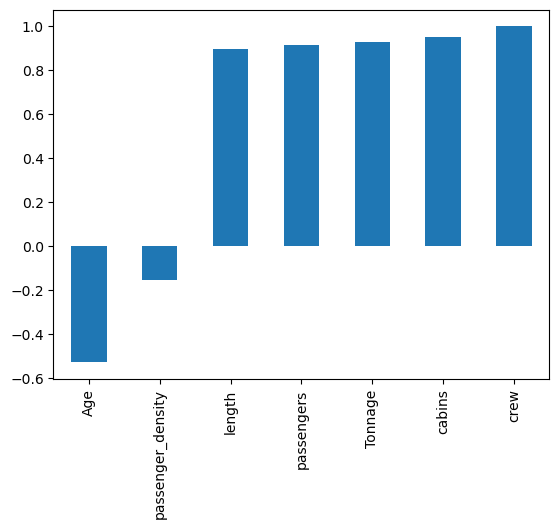

In [72]:
dataf.corr()["crew"][:7].sort_values().plot(kind = "bar")

In [21]:
from siuba import *

In [22]:
x = dataf >> select(-_.crew) #Eligo todas menos la columna de crew
y = dataf >> select(_.crew)  #Solo eligo la columna crew

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 101)

In [26]:
#Para el escalado:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [27]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [31]:
#Para crear el modelo:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [29]:
x_train.shape[1]

26

In [30]:
num_neuronas = x_train.shape[1]

In [73]:
modelo = Sequential()

modelo.add(Dense(units = num_neuronas, activation = "relu"))
modelo.add(Dense(units = num_neuronas//2, activation = "relu"))

modelo.add(Dense(1))

modelo.compile(
    optimizer = "adam",
    loss = "mse"
)

In [74]:
#Para el entrenamiento:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = "val_loss", patience = 4)

In [75]:
modelo.fit(
    x = x_train,
    y = y_train,
    epochs = 500,
    validation_data = (x_test, y_test),
    callbacks = [early_stop],
    verbose = False
)

<AxesSubplot:>

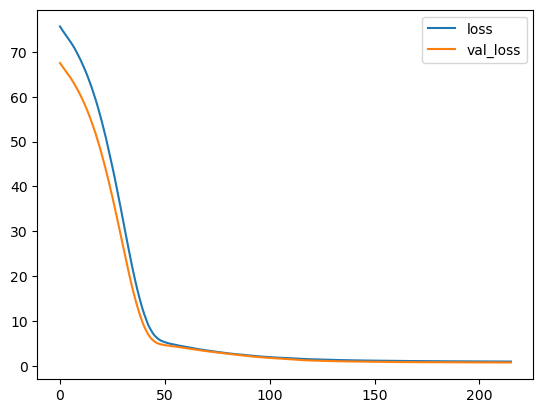

In [76]:
pd.DataFrame(modelo.history.history).plot()

In [42]:
from sklearn.metrics import r2_score, mean_squared_error

In [77]:
prediccion = modelo.predict(x_test)

2/2 [==============================] - 0s 2ms/step


Veremos en general que los valores de la raíz del error cuadrático medio y del R2 son bastante buenos, considerando la media y la desviación estándar de los datoa de Crew

In [78]:
np.sqrt(mean_squared_error(prediccion, y_test))

0.8526799425664612

In [79]:
abs(r2_score(prediccion, y_test))

0.93507141646254

In [80]:
data["crew"].describe()

count    158.000000
mean       7.794177
std        3.503487
min        0.590000
25%        5.480000
50%        8.150000
75%        9.990000
max       21.000000
Name: crew, dtype: float64

Y usando los propios datos del dataframe original

In [81]:
nuevo_data = data

In [82]:
x_scaler = scaler.transform(x)

In [83]:
prediccion_x = modelo.predict(x_scaler)

5/5 [==============================] - 0s 1ms/step


In [84]:
nuevo_data["Prediccion"] = prediccion_x
nuevo_data

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew,Prediccion
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55,3.503781
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55,3.503781
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70,6.666139
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10,12.454665
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00,11.193881
...,...,...,...,...,...,...,...,...,...,...
153,Taurus,Star,22,3.341,0.66,2.79,0.33,50.62,0.59,1.698792
154,Virgo,Star,14,76.800,19.60,8.79,9.67,39.18,12.00,8.857937
155,Spirit,Windstar,25,5.350,1.58,4.40,0.74,33.86,0.88,0.440492
156,Star,Windstar,27,5.350,1.67,4.40,0.74,32.04,0.88,0.409544


In [86]:
import matplotlib.pyplot as plt

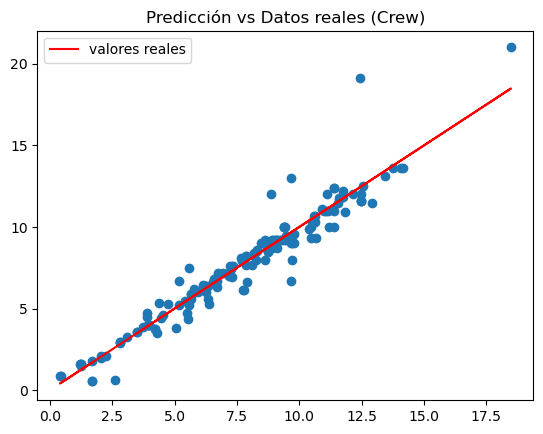

In [89]:
plt.scatter(x = nuevo_data["Prediccion"], y = nuevo_data["crew"])
plt.plot(nuevo_data["Prediccion"], nuevo_data["Prediccion"], label = "valores reales", color = "r")
plt.title("Predicción vs Datos reales (Crew)")
plt.legend()
plt.show()